# Štatistický projekt - PSt 1, Matúš Jurčák

V rámci svojho štatistického projektu sa zameriam na analýzu zápasov TOP 25 profesionálnych tímov v hre Counter-Strike (aktuálne Counter-Strike 2) v období od 1.1.2025 do 31.7.2025. Ako rebríček som použil HLTV World Ranking. V prvom teste budem skúmať vzťah medzi počtom odohraných máp a vyhranými kolami a v druhom teste overím, či ma výhra pistol round vplyv na výhru polovice zápasu.

## Dáta

Svoje dáta som bral zo stránky HLTV.org, kde sú dostupné podrobné štatistiky zápasov a tímov. Všetky dáta sú dostupné v priečinku `data` ako JSON súbory.

V prvom teste budem používať dáta z priečinku `data/matches`. Pre každý tím mám k dispozícii súbor JSON, ktorý obsahuje hlavné informácie o všetkých jeho zápasoch.

V druhom teste budem používať dáta z priečinku `data/maps`, kde mám pre každý tím agregované dáta zo všetkých ním odohraných máp.

*Poznámka: Celá pätica hráčov tímu **Aurora**, bola odkúpená začiatkom Apríla z tímu **Eternal Fire**. Rozhodol som sa zahrnúť všetky ich zápasy aj v tíme **Aurora**, tak aj v tíme **Eternal Fire** a v grafe sú označení len ako **Aurora**.*

# Test 1

V tomto teste budem skúmať, či existuje vzťah medzi počtom odohraných máp a vyhranými kolami. Očakávam, že čím viac máp tím odohrá, tým viac kôl vyhrá. Teda spustím na dáta lineárnu regresiu.

**Nulová hypotéza**: Neexistuje lineárny vzťah medzi počtom odohraných máp a vyhranými kolami

**Alternatívna hypotéza**: Existuje lineárny vzťah medzi počtom odohraných máp a vyhranými kolami.

## Načítanie a formátovanie dát

In [28]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import numpy as np
import statsmodels.api as sm

DATA_DIR = './data/matches'

teams = [
    ["3DMAX", "all-matches-3dmax.json"],
    ["Astralis", "all-matches-astralis.json"],
    ["Aurora", "all-matches-aurora.json"],
    ["B8", "all-matches-b8.json"],
    ["Complexity", "all-matches-complexity.json"],
    ["Falcons", "all-matches-falcons.json"],
    ["FaZe", "all-matches-faze.json"],
    ["FURIA", "all-matches-furia.json"],
    ["G2", "all-matches-g2.json"],
    ["GamerLegion", "all-matches-gamerlegion.json"],
    ["HEROIC", "all-matches-heroic.json"],
    ["Legacy", "all-matches-legacy.json"],
    ["Liquid", "all-matches-liquid.json"],
    ["Lynn Vision", "all-matches-lynn-vision.json"],
    ["MIBR", "all-matches-mibr.json"],
    ["The MongolZ", "all-matches-mongolz.json"],
    ["MOUZ", "all-matches-mouz.json"],
    ["Natus Vincere", "all-matches-navi.json"],
    ["Ninjas in Pyjamas", "all-matches-nip.json"],
    ["paiN", "all-matches-pain.json"],
    ["SAW", "all-matches-saw.json"],
    ["Spirit", "all-matches-spirit.json"],
    ["TYLOO", "all-matches-tyloo.json"],
    ["Vitality", "all-matches-vitality.json"],
    ["Virtus.pro", "all-matches-vp.json"],
]


team_data = []

for team_name, file_name in teams:
    with open(os.path.join(DATA_DIR, file_name), "r") as f:
        matches = json.load(f)
    maps_played = 0
    rounds_won = 0

    for match in matches:
        for map in match.get("maps"):
            if map.get("result"):
                if team_name == "Aurora":
                    if match.get("team1").get("name") == team_name or match.get("team1").get("name") == "Eternal Fire":
                        maps_played += 1
                        rounds_won += map["result"].get("team1TotalRounds", 0)
                    elif match.get("team2").get("name") == team_name or match.get("team2").get("name") == "Eternal Fire":
                        maps_played += 1
                        rounds_won += map["result"].get("team2TotalRounds", 0)
                else:
                    if match.get("team1").get("name") == team_name:
                        maps_played += 1
                        rounds_won += map["result"].get("team1TotalRounds", 0)
                    elif match.get("team2").get("name") == team_name:
                        maps_played += 1
                        rounds_won += map["result"].get("team2TotalRounds", 0)
    team_data.append({
        "team": team_name,
        "maps": maps_played,
        "rounds": rounds_won
    })

df = pd.DataFrame(team_data)

print(df)

                 team  maps  rounds
0               3DMAX   109    1212
1            Astralis   133    1487
2              Aurora   130    1531
3                  B8   146    1679
4          Complexity    81     942
5             Falcons   132    1516
6                FaZe   105    1205
7               FURIA   116    1297
8                  G2    96    1095
9         GamerLegion   112    1243
10             HEROIC   129    1467
11             Legacy   159    1708
12             Liquid    85     864
13        Lynn Vision   118    1266
14               MIBR    84     845
15        The MongolZ   109    1258
16               MOUZ   116    1337
17      Natus Vincere    81     928
18  Ninjas in Pyjamas   168    1971
19               paiN   114    1180
20                SAW    90     925
21             Spirit    93    1191
22              TYLOO   142    1600
23           Vitality   108    1342
24         Virtus.pro    95    1022


Pozrieme sa, ako dáta vyzerajú v grafe.

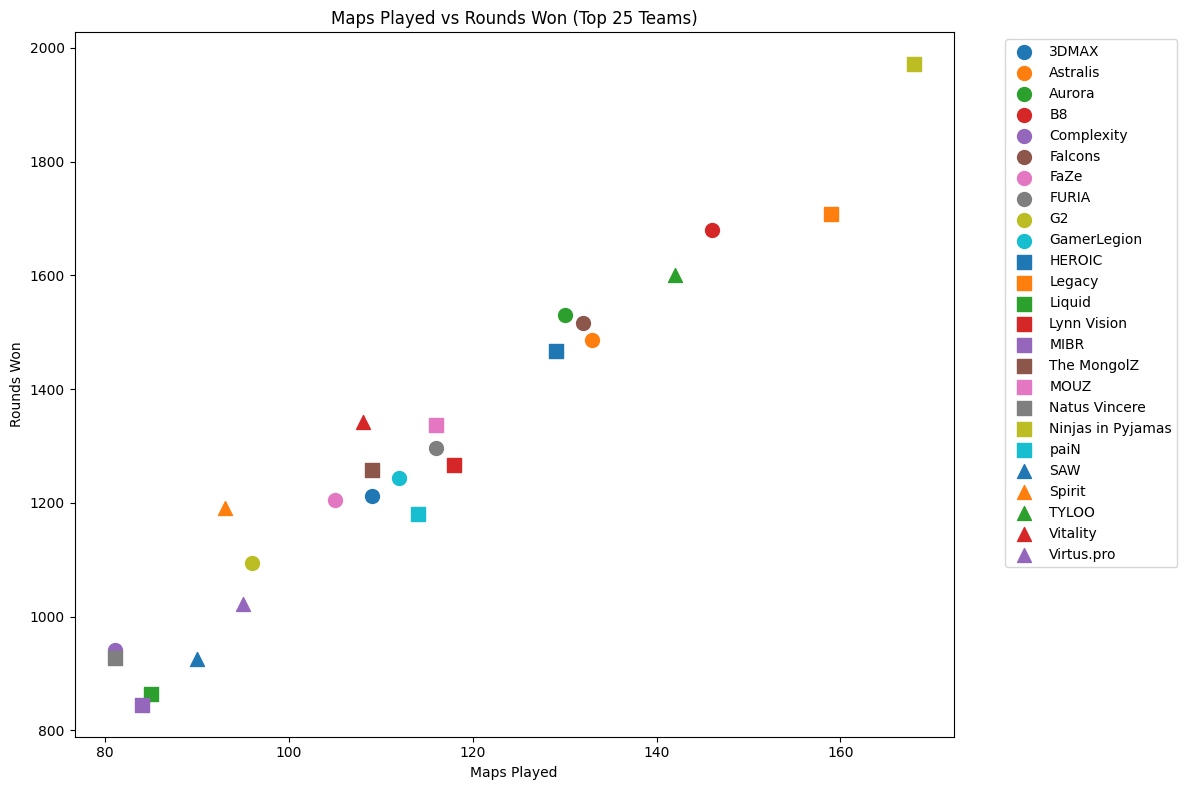

In [29]:
colors = plt.cm.tab10.colors
markers = ["o", "s", "^"]

plt.figure(figsize=(12, 8))

for i, row in df.iterrows():
    color = colors[i % len(colors)]
    marker = markers[i // len(colors)]
    
    plt.scatter(
        row["maps"], 
        row["rounds"], 
        color=color, 
        marker=marker, 
        s=100,
        label=row["team"]
    )

plt.xlabel("Maps Played")
plt.ylabel("Rounds Won")
plt.title("Maps Played vs Rounds Won (Top 25 Teams)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Následne si spočítam priemerný počet vyhraných kôl a priemerný počet odohraných máp. Zároveň si spočítam a a b pre regresiu.

In [30]:
maps = df["maps"].values
rounds = df["rounds"].values

maps_mean = np.mean(maps)
rounds_mean = np.mean(rounds)

a = np.sum((maps - maps_mean) * (rounds - rounds_mean)) / np.sum((maps - maps_mean)**2)
b = rounds_mean - a * maps_mean

print("Average maps played:", maps_mean)
print("Average rounds won:", rounds_mean)
print("Regression coefficients:")
print("a:", a)
print("b:", b)
print("The linear model is: Y = {:.5} + {:.5}*X".format(b, a))

Average maps played: 114.04
Average rounds won: 1284.44
Regression coefficients:
a: 11.705194684129879
b: -50.42040177817148
The linear model is: Y = -50.42 + 11.705*X


Vložíme priamku do grafu:

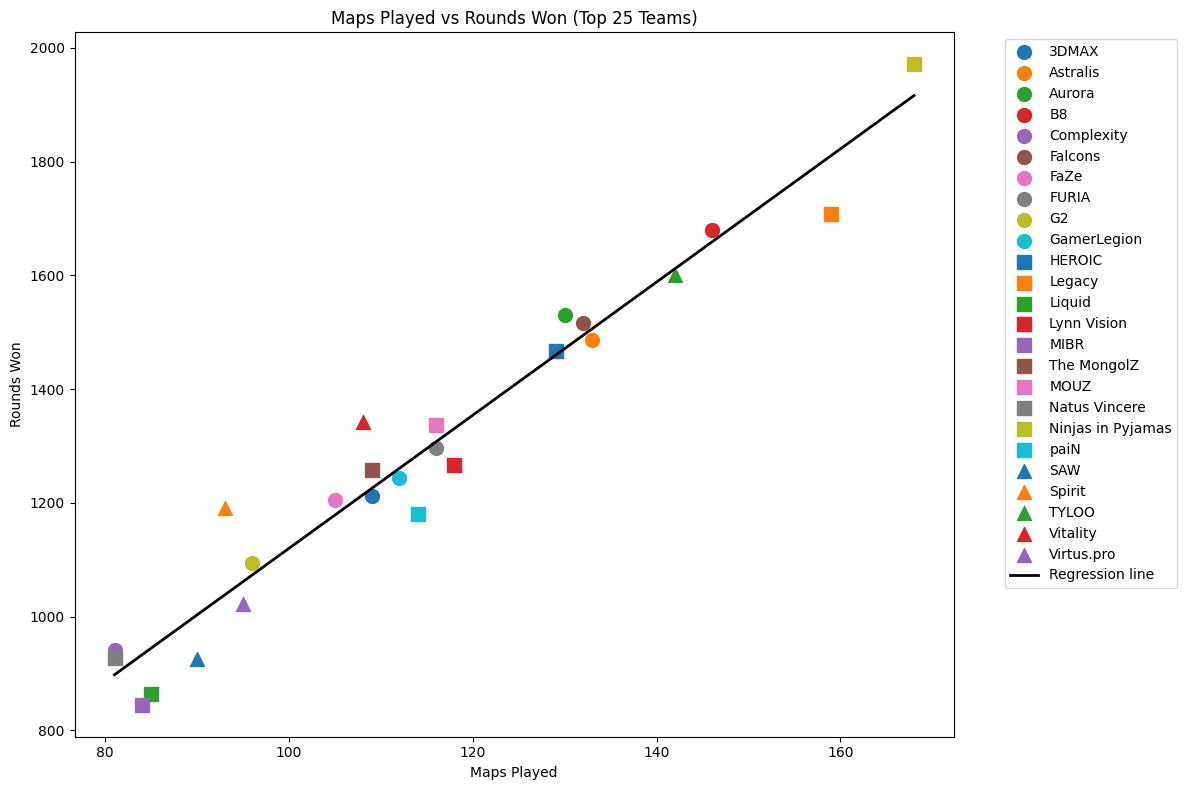

In [31]:
plt.figure(figsize=(12, 8))

for i, row in df.iterrows():
    color = colors[i % len(colors)]
    marker = markers[i // len(colors)]
    
    plt.scatter(
        row["maps"], 
        row["rounds"], 
        color=color, 
        marker=marker, 
        s=100,
        label=row["team"]
    )

x_line = np.linspace(df["maps"].min(), df["maps"].max(), 100)
y_line = a * x_line + b
plt.plot(x_line, y_line, color="black", linewidth=2, label="Regression line")

plt.xlabel("Maps Played")
plt.ylabel("Rounds Won")
plt.title("Maps Played vs Rounds Won (Top 25 Teams)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Na to, aby sme zistili p-hodnotu, pridáme počet odohraných máp ako konštantu a vykonáme OLS regresiu.


In [ ]:
X = sm.add_constant(maps)
model = sm.OLS(rounds, X)
results = model.fit()

print(results.summary())
print(f"P-hodnota je {results.pvalues[1]:.25f}", )

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     424.9
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           2.50e-16
Time:                        17:25:32   Log-Likelihood:                -139.38
No. Observations:                  25   AIC:                             282.8
Df Residuals:                      23   BIC:                             285.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.4204     66.110     -0.763      0.4

## Záver

Keďže je p-hodnota menšia ako 0.05, môžeme zamietnuť nulovú hypotézu a usúdiť, že medzi počtom odohraných máp a počtom vyhraných kôl existuje lineárny vzťah.

# Test 2

V tomto teste budem skúmať, či existuje vzťah medzi výhrou pistol round (prvého kola polovice) a výhrou polovice. Očakávam, že pokiaľ tím vyhrá pistol round, tak má väčsiu šancu vyhrať polovicu.

**Nulová hypotéza**: Pravdepodobnosť, že tím vyhrá polovicu, potom ako vyhral pistol round je 0.5.

**Alternatívna hypotéza**: Pravdepodobnosť, že tím vyhrá polovicu, potom ako vyhral pistol round nie je 0.5.

Na otestovanie hypotézy použijem obojstranný t-test.

## Načítanie a formátovanie dát

In [33]:
import json
import os
from collections import defaultdict
from scipy import stats
import numpy as np

DATA_DIR = "./data/maps/"

all_halves = []
seen_map_ids = {}

for file_name in os.listdir(DATA_DIR):
    if file_name.endswith(".json"):
        with open(os.path.join(DATA_DIR, file_name), "r") as f:
            maps = json.load(f)

        for m in maps:
            map_id = m["mapId"]
            if map_id in seen_map_ids:
                continue
            seen_map_ids[map_id] = m

            if m["pistol1Winner"] and m["half1Outcome"]:
                all_halves.append(1 if m["pistol1Winner"] == m["half1Outcome"] else 0)

            if m["pistol2Winner"] and m["half2Outcome"]:
                all_halves.append(1 if m["pistol2Winner"] == m["half2Outcome"] else 0)
                                
data = np.array(all_halves)

print(f"Počet vzorkov: {len(data)}")
print(f"Počet vyhraných polovíc po vyhranom pistol round-e: {all_halves.count(1)}")
print(f"Podiel výher polovice po výhre pistol round ku všetkým poloviciam: {data.mean():.5f}")

Počet vzorkov: 3768
Počet vyhraných polovíc po vyhranom pistol round-e: 2171
Podiel výher polovice po výhre pistol round ku všetkým poloviciam: 0.57617


Teraz spravím obostranný t-test pomocou funkcie z knižnice `scipy.stats`

In [34]:
t_stat, p_value = stats.ttest_1samp(data, 0.5, axis=None, alternative='two-sided')

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.25f}")

T-statistic: 9.460
P-value: 0.0000000000000000000052509


Mohli by sme sa ešte pozrieť, aká by bola p-value pokiaľ použijeme jednostranný test a ako alternatíva bude, že pravdepodonosť je vyššia než 0.5.

In [35]:
t_stat, p_value = stats.ttest_1samp(data, 0.5, axis=None, alternative='greater')

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.25f}")

T-statistic: 9.460
P-value: 0.0000000000000000000026254


## Záver

Keďže p-value je menšie ako 0.05, môžeme zamietnuť nulovú hypotézu a prijať alternatívnu hypotézu, teda že pravdepodobnosť nie je 0.5.

Z jednostranného testu je zrejmé, že výhra pistol round má významný vplyv na výhru polovice a teda je väčšia pravdepodobnosť, že tím vyhrá polovicu, ak vyhrá aj pistol round.